In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
train.head(10)

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


In [4]:
duplicate_rows_data = train[train.duplicated()]
print("Number of duplicate rows: ", duplicate_rows_data.shape)

Number of duplicate rows:  (0, 6)


In [5]:
desc = pd.DataFrame(index = list(train))
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] / len(train) * 100
desc['null'] = train.isnull().sum()
desc['type'] = train.dtypes
desc = pd.concat([desc, train.describe().T.drop('count', axis = 1)], axis = 1)
desc

,count,nunique,%unique,null,type,mean,std,min,25%,50%,75%,max
id,136950,136950,100.000000,0,int64,68474.500000,39534.204020,0.0,34237.25,68474.5,102711.75,136949.0
date,136950,1826,1.333333,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,136950,5,0.003651,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store,136950,3,0.002191,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product,136950,5,0.003651,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_sold,136950,1028,0.750639,0,int64,165.522636,183.691575,2.0,46.00,98.0,184.00,1380.0


In [6]:
# feature recasting, cast date as datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [7]:
#plt.figure(figsize = (20, 10), dpi = 300)

#sns.lineplot(data = train, x = 'date', y = 'num_sold')
    
#plt.title('Sales Over Time', fontsize = 24, fontweight = 'bold')
#plt.show()

In [8]:
#plt.figure(figsize = (20, 10), dpi = 300)

#sns.lineplot(data = train, x = 'date', y = 'num_sold', hue = 'country')
    
#plt.title('Sales Over Time per Country', fontsize = 24, fontweight = 'bold')
#plt.show()

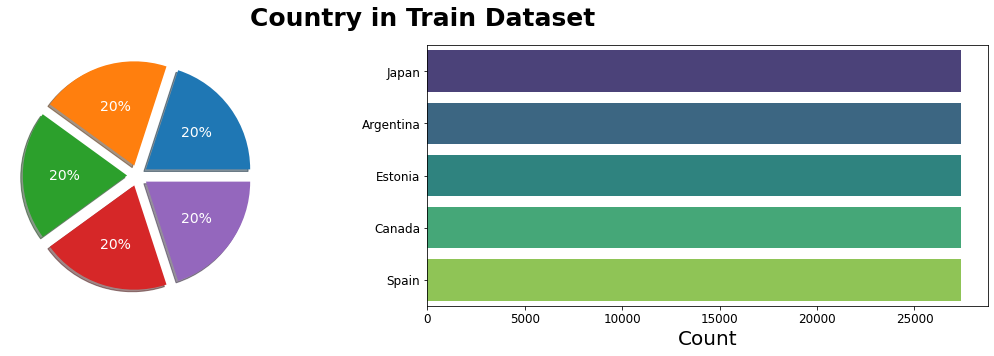

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    train['country'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(0, 5)], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = train, y = 'country', ax = ax[1], palette = 'viridis', order = train['country'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Country in Train Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

In [10]:
def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021, 2022]

    holiday_AR = holidays.CountryHoliday('AR', years=years_list)
    holiday_CA = holidays.CountryHoliday('CA', years=years_list)
    holiday_EE = holidays.CountryHoliday('EE', years=years_list)
    holiday_JP = holidays.CountryHoliday('JP', years=years_list)
    holiday_ES = holidays.CountryHoliday('ES', years=years_list)

    holiday_dict = holiday_AR.copy()
    holiday_dict.update(holiday_CA)
    holiday_dict.update(holiday_EE)
    holiday_dict.update(holiday_JP)
    holiday_dict.update(holiday_ES)

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')

    return df

# Assume enc is an instance of OrdinalEncoder()
def encode_holiday_names(df, enc, subset='train'):
    if subset=='train':
        df['holiday_name'] = enc.fit_transform(df['holiday_name'].values.reshape(-1,1))
    else:
        df['holiday_name'] = enc.transform(df['holiday_name'].values.reshape(-1,1))
        not_hol_val = oe.transform([['Not Holiday']])[0,0]
        df.loc[df['holiday_name']==-1, 'holiday_name'] = not_hol_val
    return df

In [11]:
def datetime_features(df_temp):
    df_temp['month'] = df_temp['date'].dt.month
    df_temp['day'] = df_temp['date'].dt.day
    df_temp['year'] = df_temp['date'].dt.year
    df_temp['dayofweek'] = df_temp['date'].dt.dayofweek
    df_temp['quarter'] = df_temp['date'].dt.quarter
    df_temp['dayofmonth'] = df_temp['date'].dt.day
    df_temp['weekofyear'] = df_temp['date'].dt.weekofyear
    df_temp['is_month_start'] = df_temp.date.dt.is_month_start.astype(np.int8)
    df_temp['is_month_end'] = df_temp.date.dt.is_month_end.astype(np.int8)
    df_temp['monday'] = df_temp.date.dt.weekday.eq(0).astype(np.uint8)
    df_temp['tuesday'] = df_temp.date.dt.weekday.eq(1).astype(np.uint8)
    df_temp['wednesday'] = df_temp.date.dt.weekday.eq(2).astype(np.uint8)
    df_temp['thursday'] = df_temp.date.dt.weekday.eq(3).astype(np.uint8)
    df_temp['friday'] = df_temp.date.dt.weekday.eq(4).astype(np.uint8)
    df_temp['saturday'] = df_temp.date.dt.weekday.eq(5).astype(np.uint8)
    df_temp['sunday'] = df_temp.date.dt.weekday.eq(6).astype(np.uint8)
    df_temp['is_quarter_end'] = df_temp['date'].dt.is_quarter_end
    df_temp['is_quarter_start'] = df_temp['date'].dt.is_quarter_start
    df_temp['is_year_end'] = df_temp['date'].dt.is_year_end
    df_temp['is_year_start'] = df_temp['date'].dt.is_year_start
    
    return df_temp

In [12]:
def seasonality_features(df_temp):
    df_temp['month_sin'] = np.sin(2*np.pi*df_temp.month/12)
    df_temp['month_cos'] = np.cos(2*np.pi*df_temp.month/12)
    df_temp['day_sin'] = np.sin(2*np.pi*df_temp.day/24)
    df_temp['day_cos'] = np.cos(2*np.pi*df_temp.day/24)
    return df_temp


In [13]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train = get_holidays(train)
test = get_holidays(test)

# Create features from 'date'
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['dayofweek'] = train['date'].dt.dayofweek

# Fill NA values caused by moving average
train = train.fillna(method='bfill')

# One-hot encoding
train = pd.get_dummies(train, columns=['country', 'store', 'product'])

# Define features X and target y
X = train.drop(['id', 'num_sold'], axis=1)
y = train[['num_sold']]

### Do same for test data set
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek

# One-hot encoding
test = pd.get_dummies(test, columns=['country', 'store', 'product'])

ids = test['id']
test = test.drop(['id'], axis=1)

X = encode_holiday_names(X, oe)
test = encode_holiday_names(test, oe)
X = datetime_features(X)
test = datetime_features(test)
X = seasonality_features(X)
test = seasonality_features(test)

X = X.drop(['date', 'year'], axis=1)
test = test.drop(['date', 'year'], axis=1)



c:\users\jason nguyen\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
c:\users\jason nguyen\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


KeyError: "['Month_Year'] not found in axis"

In [ ]:
X.head(10)

In [ ]:
test.head(10)

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.multioutput import RegressorChain


lgbm = LGBMRegressor(n_estimators=2000, learning_rate=0.01, num_leaves=50, random_state=42, verbose = -1)
xgb =  RegressorChain(base_estimator=XGBRegressor(max_depth= 7, n_estimators= 200,
                                                  learning_rate= 0.01, random_state=42))
cat = CatBoostRegressor(colsample_bylevel= 0.6767696482697301,
    l2_leaf_reg =  8.601133541582584,
    learning_rate =  0.05,
    max_depth = 9,
    random_state = 42,
    subsample = 0.4279526734063217,
    verbose = False)

models = [lgbm, xgb, cat]


In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scaler = StandardScaler()

lowestErr = np.inf
mae_scores = list()

for train_ix, valid_ix in skf.split(X, y):
    i = 0
    X_train, X_valid = X.iloc[train_ix], X.iloc[valid_ix]
    y_train, y_valid = y.iloc[train_ix], y.iloc[valid_ix]
    
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_valid_scaled = pd.DataFrame(scaler.fit_transform(X_valid), columns=X_valid.columns)
    
    for model in models:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_valid_scaled)
        
        print(str(model)[:-2], i)
        print("\tExplained variance:", explained_variance_score(y_valid, y_pred))
        mae = mean_absolute_error(y_valid, y_pred)
        print("\tMean absolute error:",mae)
        print("\tR2 score:", r2_score(y_valid, y_pred))
        
        if mae < lowestErr:
            best_model = model
            lowestErr = mae
            print('best_model_saved')
        mae_scores.append(mae)
    i += 1
        
print('Loss MAE:', np.mean(mae_scores))
print('Best MAE:', lowestErr)

In [ ]:
best_model

In [ ]:
y_pred = best_model.predict(test)
y_pred

In [ ]:
submit = pd.DataFrame(y_pred, columns = ['num_sold'])

submit['id'] = ids
submit = submit[['id','num_sold']]

submit.head()

In [ ]:
submit.to_csv('submission6.csv', index=False)

In [ ]:
submit